In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import datetime
from tqdm import tqdm#_notebook as tqdm
import multiprocessing
import gzip
from matplotlib import pyplot as plt
import itertools

In [2]:
ATTS_SAMPLE = 100#00
HOTEL_DATE_SAMPLE = 10#00
DATE_RANGE = range(100,110,2)
POOL_NUM = multiprocessing.cpu_count() * 8
SPLIT_NUM = POOL_NUM * 2

In [3]:
def getterm(term):
    r = requests.get('https://www.hotels.com/siteindex_www_hotels_com.xml')
    todf = []
    citylinks = [x.text for x in BeautifulSoup(r.content,'lxml').find_all('loc') if '/%s_www' % term in x.text]
    for city in tqdm(citylinks):
        r2 = requests.get(city)
        soup = BeautifulSoup(gzip.decompress(r2.content),'lxml')
        todf.append(pd.DataFrame([{'name':x.find('loc').text.split('/')[-2],
                                   'id':x.find('loc').text.split('/')[-3][2:],
                                   'url':x.find('loc').text
                                  } for x in soup.find_all('url')])
        )
    return pd.concat(todf)

In [4]:
def recmerge(df1,df2,collist,targetcol):
    out = []
    for col in collist:
        if len(out) < 1:
            out.append(df1.merge(df2[[col,targetcol]],on=col,how='left'))
        else:
            out.append(out[-1][out[-1][targetcol].isnull()].drop(targetcol,axis=1
                       ).merge(df2[[col,targetcol]],on=col,how='left'))
    return pd.concat([x[~x['id'].isnull()] for x in out])

In [5]:
fullhotel = getterm('HOTEL')

100%|██████████| 21/21 [01:36<00:00,  4.19s/it]


In [18]:
def process_hotel(hotelid):
    hotelid = str(hotelid)
    result = {'hotelid':hotelid}
    soup = BeautifulSoup(requests.get('https://www.hotels.com/ho' + hotelid,
                                     params={'locale':'en_IE'}).content,'html5lib')
    for vcard in soup.find_all('div',{'class':'property-description'}):
        for fun, name in [[lambda x: x.find('h1').text,'name'],
                         [lambda x: x.find('span',{'class':'hotel-coordinates'}
                                          ).find_all('meta')[0]['content'],'lat'],
                         [lambda x: x.find('span',{'class':'hotel-coordinates'}
                                          ).find_all('meta')[1]['content'],'lon'],
                         [lambda x: x.find('span',{'class','star-rating-text'}).text,'star'],
                         [lambda x: x.find('span',{'class','street-address'}).text,'street'],
                         [lambda x: x.find('span',{'class','locality'}).text,'locality'],
                         [lambda x: x.find('span',{'class','region'}).text,'region'],
                         [lambda x: x.find('span',{'class','postal-addr'}).text,'addr'],
                         [lambda x: x.find('span',{'class','postal-code'}).text,'zip'],
                         [lambda x: x.find('span',{'class','country-name'}).text,'country'],
                         [lambda x: x.find('div',{'class','tagline'}).text,'tagline']]:
            try:
                result[name] = fun(vcard)
            except:
                #print('FUCKED ----------- %s --- %s' % (name,hotelid))
                pass
    try:
        result['dest-id'] = soup.find('span',{'class':'back-link'}).find('a')['href'].split(
            'destination-id=')[-1].split('&')[0]
    except:
        #print('FUCKED ----------- %s --- %s' % ('dest-id',hotelid))
        pass
    for findict,name in [[{'data-overview-section-type':"HOTEL_FEATURE"},'base'],
                        [{'data-overview-section-type':"FAMILY_FRIENDLY_SECTION"},'family'],
                        [{'class':'key-facts-container'},'key'],
                        [{'class':'travelling-container'},'travel'],
                        [{'class':'transport-container'},'transport'],
                        [{'class':'badges-and-services-container'},'badges']]:
        baselist = soup.find('div',findict)
        try:
            lis = baselist.find_all('li')
        except:
            #print('FUCKED ----------- %s --- %s' % (name,hotelid))
            lis = []
            result[name + '_missing'] = 1
        for li in lis:
            num_found = False
            for reg,num_name in [['This hotel has (\d+)','rooms'],
                        ['This hotel is arranged over (\d+)','floors'],
                        ['(\d+) restaurants','restaurants'],
                        ['(\d+) outdoor pools','outdoor pools'],
                        ['(\d+) spa tubs','spa tubs'],
                        ['(\d+) bars/lounges','bars/lounges'],
                        ['(\d+) poolside bars','poolside bars'],
                        ['(\d+) poolside bars','poolside bars'],
                        ['(\d) smoke-free guestrooms','smoke-free guestrooms'],
                        ['(\d) guestrooms','guestrooms'],
                        ['(\d) apartments','apartments'],
                        ['(\d) smoke-free apartments','smoke-free apartments'],
                        ['(\d) inch flat-screen TV','inch flat-screen TV'],
                        ['(\d) inch LCD TV','inch LCD TV'],
                        ['(\d) inch TV','inch TV'],
                        ['(\d) Smart TV','Smart TV'],
                        ['(\d) LED TV','LED TV'],
                        ['(\d) inch plasma TV','inch plasma TV'],
                        ['(\d) villas','villas'],
                        ['(\d) smoke-free accommodations','smoke-free accommodations']]:
                ref = re.findall(reg,li.text)
                if len(ref) > 0:
                    result[num_name] = ref[0]
                    num_found = True
            if num_found:
                continue
            if name == 'key':
                if 'Check-in time' in li.text:
                    result['Check-in time'] = li.text.split('time ')[-1]
                    continue
                if 'Check-out time' in li.text:
                    result['Check-out time'] = li.text.split('time ')[-1]
                    continue
            result[name + '_' + li.text] = 1


    for findict,name in [[{'class':'fact-sheets in-the-property-module'},'inhotel'],
                         [{'class':'fact-sheets in-the-room-module'},'inroom']]:    
        inhotel = soup.find('div',findict)
        try:
            lis = inhotel.find_all('div',{'class':'fact-sheet-table-row'})
        except:
            #print('FUCKED ----------- %s --- %s' % (name,hotelid))
            result[name + '_missing'] = 1
            lis = []
        for li in lis:
            head = li.find('div',{'class':'fact-sheet-table-header'})
            try:
                head = head.text
                cells = li.find_all('li')
            except:
                #print('FUCKED ----------- %s --- %s' % (name,hotelid))
                cells = []
            for item in cells:
                result[name + '_' + head + '_' + item.text] = 1
    return result

def mp_hotel_list(hlist):
    return pd.DataFrame([process_hotel(h) for h in hlist])

In [19]:
def roomparse(room):
    roomdict = {}
    try:
        detli = room.find('div',{'class':'room-details'}).find_all('li')
    except:
        detli = []
        roomdict['details_missing'] = 1
    for li in detli:
        roomdict[li.text] = 1

    try:
        inputli = room.find('form').find_all('input')
    except:
        inputli = []
    for inp in inputli:
        try:
            roomdict[inp['name']] = inp['value']
        except:
            pass

    for feature in room.find_all('span',{'class':'feature-title'}):
        roomdict[feature.text] = 1

    for fun,name in [[lambda x: x.find('h3').text,'room_name'],
                    [lambda x: x.find('span',{'class':'occupancy-rate'}).text,'occupancy'],
                    [lambda x: x.find('div',{'class':'cancellation'}).text.split()[0],'cancellation'],
                    [lambda x: x.find('strong',{'class':'current-price'}).text,'price'],
                    [lambda x: x.find('div',{'class':'price'}).text,'price-2'],
                    [lambda x: x['data-index'],'data-index']]:
        try:
            roomdict[name] = fun(room)
        except:
            pass
    return roomdict

def process_date(inlist):
    hotelid = inlist[0]
    date=inlist[1]
    chin = date.strftime('%Y-%m-%d')
    chout = (date + datetime.timedelta(days = 1)).strftime('%Y-%m-%d')
    params = {'q-check-out':chout,
              'q-check-in':chin,
              'q-room-0-adults':2,
              'q-rooms':1,
              'q-room-0-children':0,
              'locale':'en_IE'}
    url = 'https://www.hotels.com/ho' + str(hotelid)
    
    r = requests.get(url,params=params)
    #print(r.url)
    rooms = BeautifulSoup(r.content,'html5lib').find_all('li',{'class':'room'})
    hotelinfo = {'hotelid':hotelid,
                'date':chin,
                'rooms':len(rooms)}
    return pd.DataFrame([roomparse(r) for r in rooms]),hotelinfo

def process_dateoutput(outlist):
    return pd.concat([x[0] for x in outlist]),pd.DataFrame([x[1] for x in outlist])

In [20]:
pool = multiprocessing.Pool(POOL_NUM)

In [21]:
hotel_atts = pd.concat(pool.map(mp_hotel_list,[hlist for
                        hlist in np.array_split(
                        fullhotel['id'].sample(ATTS_SAMPLE).values,SPLIT_NUM)])).set_index('hotelid')

/home/borza/Dropbox/Papers_write/ma_thesis/hierarchical-genmodel/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
hotel_atts.to_csv('../data/external/hotel-atts.csv')

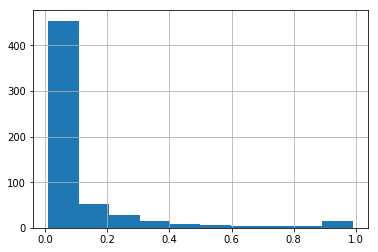

In [23]:
pd.Series([(1 - hotel_atts[col].isnull().sum() / hotel_atts.shape[0]) for
           col in hotel_atts.columns],index = hotel_atts.columns).sort_values().hist()
plt.show()

In [24]:
hotelsamplesize = HOTEL_DATE_SAMPLE
daterange = DATE_RANGE

pairs = itertools.product(hotel_atts.sample(hotelsamplesize).index,
                  [(datetime.date.today() + datetime.timedelta(days = d))
                   for d in daterange])

roomdf,hoteldates = process_dateoutput(pool.map(process_date,[l for l in list(pairs)]))

/home/borza/Dropbox/Papers_write/ma_thesis/hierarchical-genmodel/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [25]:
roomdf.to_csv('../data/external/roomdf.csv',index=None)
hoteldates.to_csv('../data/external/hoteldates.csv',index=None)

In [26]:
for c in roomdf.columns:
    print(c)
    print(roomdf[c].value_counts())
    print(len(roomdf[c].unique()))
    print(roomdf[c].isnull().sum())
    print('\n\n\n')

Air conditioning
1.0    25
Name: Air conditioning, dtype: int64
2
50




Breakfast for 2
1.0    25
Name: Breakfast for 2, dtype: int64
2
50




Breakfast for 2 people
1.0    40
Name: Breakfast for 2 people, dtype: int64
2
35




Cable TV service
1.0    45
Name: Cable TV service, dtype: int64
2
30




Ceiling fan
1.0    20
Name: Ceiling fan, dtype: int64
2
55




Coffee/tea maker
1.0    25
Name: Coffee/tea maker, dtype: int64
2
50




Connecting/adjoining rooms available
1.0    25
Name: Connecting/adjoining rooms available, dtype: int64
2
50




Cookware, dishware, and utensils
1.0    30
Name: Cookware, dishware, and utensils, dtype: int64
2
45




Daily housekeeping
1.0    45
Name: Daily housekeeping, dtype: int64
2
30




Desk
1.0    25
Name: Desk, dtype: int64
2
50




Flat-panel TV
1.0    45
Name: Flat-panel TV, dtype: int64
2
30




Free WiFi
1.0    45
Name: Free WiFi, dtype: int64
2
30




Free bottled water
1.0    30
Name: Free bottled water, dtype: int64
2
45




Free cribs/infa

In [27]:
hotelcols = hotel_atts.columns

In [16]:
doubles = pd.Series(hotelcols).apply(lambda x: re.findall('(.*?)\d+(.*)',x))
doubles = doubles[doubles.str.len() > 0]
doubles = doubles.apply(lambda x: pd.Series(x[0]).apply(lambda x: x.strip()))#.drop_duplicates()
doubles.apply(lambda x: '-'.join(x),axis=1).value_counts().reset_index()

,index,0
0,travel_Children (-years old and younger) stay ...,5
1,key_Minimum check-in age is-,5
2,travel_One child (-years old and younger) stay...,4
3,inroom_Be entertained_--inch flat-screen TV,4
4,inroom_Be entertained_--inch TV,3
5,travel_-per room,3
6,travel_Children (-years old and younger) not a...,3
7,inroom_Be entertained_--inch LCD TV,2
8,inroom_Be entertained_--cm flat-screen TV,2
9,travel_Up to-lb,2


In [17]:
'''fullcity = getterm('CITY')

fullcity['place'] = fullcity['name'].apply(lambda x: '-'.join(x.split('-')[1:]))
fullcity['place-1'] = fullcity['place'].apply(lambda x: x.split('-')[0])
fullcity['place-2'] = fullcity['place'].apply(lambda x: '-'.join(x.split('-')[:2]))


c = requests.get('https://www.boldtuesday.com/pages/alphabetical-list-of-all-countries-and-capitals-shown-on-list-of-countries-poster').content
capitals = pd.read_html(c,header=0)[0]
c2 = requests.get('https://en.wikipedia.org/wiki/List_of_largest_cities').content
biguns = pd.read_html(c2,header=0)[1]
c3 = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population').content
bigus = pd.read_html(c3,header=0)[4]
c4 = requests.get('https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits').content
bigeu = pd.read_html(c4,header=0)[0]
citydf = pd.concat([capitals.rename({'COUNTRY':'Nation','CAPITAL':'City'},axis='columns'),
           bigeu.rename({'Country':'Nation'},axis='columns')[['City','Nation']],
           pd.DataFrame({'City':bigus.iloc[:,[1,2]].apply(lambda x: ', '.join(x),axis=1),'Nation':'United States'}),
           biguns[['City','Nation']]]).dropna().apply(lambda x: x.apply(lambda y: y.title()))
citydf['City'] = citydf['City'].apply(lambda x: re.sub('\[.*?\]','',x))
citydf = citydf.drop_duplicates('City')

citydf['place'] = citydf.apply(lambda x: '-'.join(
    x[['City','Nation']]).lower().replace(' ','-'
                                 ).replace(',',''
                                 ).replace('-united-states',''
                                 ).replace("'",'-'
                                 ).replace('á','a')
                               ,axis=1)
citydf = citydf.drop_duplicates('place')
citydf['place-1'] = citydf.apply(lambda x: x['City'].lower(
                                 ).replace(' ','-'
                                 ).replace(',',''
                                 ).replace("'",''
                                 ).replace('á','a')
                               ,axis=1)
citydf['place-2'] = citydf['place-1']

merged_city = recmerge(citydf,fullcity,['place','place-1','place-2'],'id')'''

'fullcity = getterm(\'CITY\')\n\nfullcity[\'place\'] = fullcity[\'name\'].apply(lambda x: \'-\'.join(x.split(\'-\')[1:]))\nfullcity[\'place-1\'] = fullcity[\'place\'].apply(lambda x: x.split(\'-\')[0])\nfullcity[\'place-2\'] = fullcity[\'place\'].apply(lambda x: \'-\'.join(x.split(\'-\')[:2]))\n\n\nc = requests.get(\'https://www.boldtuesday.com/pages/alphabetical-list-of-all-countries-and-capitals-shown-on-list-of-countries-poster\').content\ncapitals = pd.read_html(c,header=0)[0]\nc2 = requests.get(\'https://en.wikipedia.org/wiki/List_of_largest_cities\').content\nbiguns = pd.read_html(c2,header=0)[1]\nc3 = requests.get(\'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population\').content\nbigus = pd.read_html(c3,header=0)[4]\nc4 = requests.get(\'https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits\').content\nbigeu = pd.read_html(c4,header=0)[0]\ncitydf = pd.concat([capitals.rename({\'COUNTRY\':\'Nation\',\'CAPITAL\':\'Ci